## Vector indexes

* Local implementation following this tutorial: https://graphacademy.neo4j.com/courses/llm-fundamentals/2-vectors-semantic-search/2-vector-index/
* Preparation:
    * Install Neo4j 5.16 (Requires Java SE 17)
    * Install Plugins:
        * gds 2.6.0
        * apoc 5.16.1
    * Download movie recommendations database dump for v5: https://github.com/neo4j-graph-examples/recommendations/tree/main/data
    * Load dump into the database:
        * https://neo4j.com/docs/operations-manual/current/backup-restore/restore-dump/
        * `./bin/neo4j-admin database load --from-path=/Users/stetelepta/work/neo4j-llm/data/ recommendations-50 --overwrite-destination=true `
        * neo4j-admin seems to still use the Java 11 version, even though I installed 17 and 21 as well:
        * Fixed by changing the JAVA_HOME environment variable just before running neo4j-admin
            `export JAVA_HOME=/Library/Java/JavaVirtualMachines/jdk-21.jdk/Contents/Home`
        * `Done: 116 files, 33.13MiB processed.`
        * Create database for the imported dump
            * ```USE system; CREATE DATABASE `recommendations-50` ```

### Requirements

In [8]:
!pip install graphdatascience python-dotenv --quiet

### Imports

In [1]:
import os
from graphdatascience import GraphDataScience
from dotenv import load_dotenv, find_dotenv
from pathlib import Path

### Settings

In [16]:
project_path = Path(os.getcwd()).parent
data_path = project_path / "data"
model_path = project_path / "models"
output_path = project_path / "output"

llm_model = "gpt-4"
database = "recommendations-50"
# load env settings
_ = load_dotenv(find_dotenv())

### Connect to Neo4j

In [19]:
gds = GraphDataScience(os.getenv('NEO4J_URL'), auth=(os.getenv('NEO4J_USER'), os.getenv('NEO4J_PASS')), database=database)
gds.run_cypher("MATCH (n) RETURN count(n)")

,count(n)
0,28863


### Vectorizing Movie Plots

GraphAcademy created a Movie Recommendation Sandbox when you enrolled in this course. The sandbox database contains over 9000 movies, 15000 actors, and over 100000 user ratings.

Each movie has a `.plot` property.

In [20]:
query = """
MATCH (m:Movie {title: "Toy Story"})
RETURN m.title AS title, m.plot AS plot
"""
gds.run_cypher(query)

,title,plot
0,Toy Story,A cowboy doll is profoundly threatened and jea...


You can use the vector index to find the most similar movies by converting the plots into vector embeddings and comparing them.

### Load embeddings

In [22]:
%%time

query = """
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/llm-fundamentals/openai-embeddings.csv'
AS row
MATCH (m:Movie {movieId: row.movieId})
CALL db.create.setNodeVectorProperty(m, 'embedding', apoc.convert.fromJsonList(row.embedding))
RETURN count(*)
"""

gds.run_cypher(query)

CPU times: user 5.27 ms, sys: 3.15 ms, total: 8.42 ms
Wall time: 1.36 s


,count(*)
0,1000


In [24]:
query = """MATCH (m:Movie {title: "Toy Story"})
RETURN m.title AS title, m.plot AS plot, m.embedding"""
df_results = gds.run_cypher(query)
df_results

,title,plot,m.embedding
0,Toy Story,A cowboy doll is profoundly threatened and jea...,"[-0.027105800807476044, -0.02422109991312027, ..."


### Create the Vector Index

You will need to create a vector index to search across these embeddings.

You will use the `db.index.vector.createNodeIndex()` procedure to create the index.

* `db.index.vector.createNodeIndex()` expects the following parameters:
* `indexName` - The name of the index
* `label` - The node label on which to index
* `propertyKey` - The property key on which to index
* `vectorDimension` - The dimension of the embedding e.g. OpenAI embeddings consist of 1536 dimensions.
* `vectorSimilarityFunction` - The similarity function to use when comparing values in this index - this can be euclidean or cosine.

In [30]:
# check embedding size
len(df_results['m.embedding'].values[0])

1536

In [31]:
query = """
CALL db.index.vector.createNodeIndex(
    'moviePlots',
    'Movie',
    'embedding',
    1536,
    'cosine'
)
"""
gds.run_cypher(query)

""


#### Check if index is online

In [36]:
query = """SHOW INDEXES"""
gds.run_cypher(query)

,id,name,state,populationPercent,type,entityType,labelsOrTypes,properties,indexProvider,owningConstraint,lastRead,readCount
0,60,__org_neo4j_schema_index_label_scan_store_conv...,ONLINE,100.0,LOOKUP,NODE,None,None,token-lookup-1.0,None,2024-02-02T10:39:46.500000000+00:00,2
1,64,constraint_3b27b0,ONLINE,100.0,RANGE,NODE,[User],[userId],range-1.0,constraint_3b27b0,None,0
2,59,constraint_3d5fcb7f,ONLINE,100.0,RANGE,NODE,[Movie],[movieId],range-1.0,constraint_3d5fcb7f,2024-02-02T10:39:09.172000000+00:00,1000
3,63,constraint_4499eae9,ONLINE,100.0,RANGE,NODE,[Person],[tmdbId],range-1.0,constraint_4499eae9,None,0
4,61,constraint_737d9c1d,ONLINE,100.0,RANGE,NODE,[Movie],[tmdbId],range-1.0,constraint_737d9c1d,None,0
5,62,constraint_f8689281,ONLINE,100.0,RANGE,NODE,[Genre],[name],range-1.0,constraint_f8689281,None,0
6,67,index_531180b4,ONLINE,100.0,RANGE,NODE,[Movie],[tagline],range-1.0,None,None,0
7,70,index_58c92700,ONLINE,100.0,RANGE,NODE,[Movie],[released],range-1.0,None,None,0
8,65,index_5c0607ad,ONLINE,100.0,RANGE,NODE,[Person],[name],range-1.0,None,None,0
9,69,index_824aad20,ONLINE,100.0,RANGE,NODE,[Movie],[imdbRating],range-1.0,None,None,0


### Querying Vectore index

In [43]:
movie_title = "Pocahontas"
nr_nearest_neighbours = 10

query = f"""
MATCH (m:Movie {{title: "{movie_title}"}})

CALL db.index.vector.queryNodes('moviePlots', {nr_nearest_neighbours}, m.embedding)
YIELD node, score

RETURN node.title AS title, node.plot AS plot, score
"""

gds.run_cypher(query)

,title,plot,score
0,Pocahontas,An English soldier and the daughter of an Algo...,1.000000
1,Braveheart,When his secret bride is executed for assaulti...,0.926007
2,Dances with Wolves,"Lt. John Dunbar, exiled to a remote western Ci...",0.922905
3,Roman Holiday,A bored and sheltered princess escapes her gua...,0.921434
4,"Little Princess, A",A young girl is relegated to servitude at a bo...,0.921403
5,Robin Hood: Prince of Thieves,When Robin and his Moorish companion come to E...,0.916718
6,"Little Princess, The",A little girl is left by her father in an excl...,0.915700
7,Private Benjamin,A sheltered young high society woman joins the...,0.914949
8,Gone with the Wind,A manipulative Southern belle carries on a tur...,0.914932
9,Emma,In rural 1800s England things go bad for a you...,0.914377


### Plot embeddings in 2D

In [208]:
%%time
# Wall time: 1.7 s

query = "MATCH (m:Movie) RETURN m.title, m.embedding"
df_results = gds.run_cypher(query)
df_results

CPU times: user 1.63 s, sys: 40.7 ms, total: 1.67 s
Wall time: 1.69 s


,m.title,m.embedding
0,Toy Story,"[-0.027105800807476044, -0.02422109991312027, ..."
1,Jumanji,"[-0.0015968380030244589, -0.022397374734282494..."
2,Grumpier Old Men,"[0.008900303393602371, -0.023931927978992462, ..."
3,Waiting to Exhale,"[-0.024737104773521423, -0.03457356244325638, ..."
4,Father of the Bride Part II,"[-0.004050840623676777, -0.024880992248654366,..."
...,...,...
9120,Mohenjo Daro,None
9121,Shin Godzilla,None
9122,The Beatles: Eight Days a Week - The Touring Y...,None
9123,The Gay Desperado,None


In [90]:
df_plot = df_results.dropna()
X = np.array([np.array(emb) for emb in df_plot['m.embedding'].values])
X.shape

(1000, 1536)

In [84]:
%%time
# Wall time: 2.93 s

import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

CPU times: user 14.6 s, sys: 10.7 s, total: 25.2 s
Wall time: 2.64 s


In [107]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_pca_norm = scaler.fit_transform(X_pca)

In [153]:
X_pca_norm[0]

array([0.31007723, 0.71197755])

In [152]:
df_plot

,m.title,m.embedding
0,Toy Story,"[-0.027105800807476044, -0.02422109991312027, ..."
1,Jumanji,"[-0.0015968380030244589, -0.022397374734282494..."
2,Grumpier Old Men,"[0.008900303393602371, -0.023931927978992462, ..."
3,Waiting to Exhale,"[-0.024737104773521423, -0.03457356244325638, ..."
4,Father of the Bride Part II,"[-0.004050840623676777, -0.024880992248654366,..."
...,...,...
1001,"Graduate, The","[-0.014425118453800678, -0.01674625091254711, ..."
1002,Touch of Evil,"[0.016380442306399345, -0.011118961498141289, ..."
1003,"Femme Nikita, La (Nikita)","[-0.02289517968893051, -0.018744437023997307, ..."
1004,"Bridge on the River Kwai, The","[0.004220117814838886, -0.02843710035085678, 0..."


#### Plot PCA with highlighted titles

In [200]:
#movie_title = "Toy Story"
#movie_title = "Heat"
movie_title = "Jurassic Park"
nr_nearest_neighbours = 20

query = f"""
MATCH (m:Movie {{title: "{movie_title}"}})

CALL db.index.vector.queryNodes('moviePlots', {nr_nearest_neighbours}, m.embedding)
YIELD node, score

RETURN node.title AS title, node.plot AS plot, score
"""

df_results = gds.run_cypher(query)
display(df_results)

selected_titles = df_results.title.tolist()

,title,plot,score
0,Jurassic Park,"During a preview tour, a theme park suffers a ...",1.000000
1,Land Before Time III: The Time of the Great Gi...,A nearby meteorite crash blocks off the dinosa...,0.923291
2,Bringing Up Baby,While trying to secure a $1 million donation f...,0.921908
3,Jumanji,When two kids find and play a magical board ga...,0.916902
4,From Dusk Till Dawn,Two criminals and their hostages unknowingly s...,0.916811
5,"Relic, The",A homicide detective and an anthropologist try...,0.915392
6,"Flintstones, The",In this live-action feature of the cartoon sho...,0.913613
7,Coneheads,Aliens with conical crania crash land on Earth.,0.912857
8,Dunston Checks In,Young boy befriends larcenous orangutan in lux...,0.912147
9,Free Willy,When a boy learns that a beloved killer whale ...,0.911036


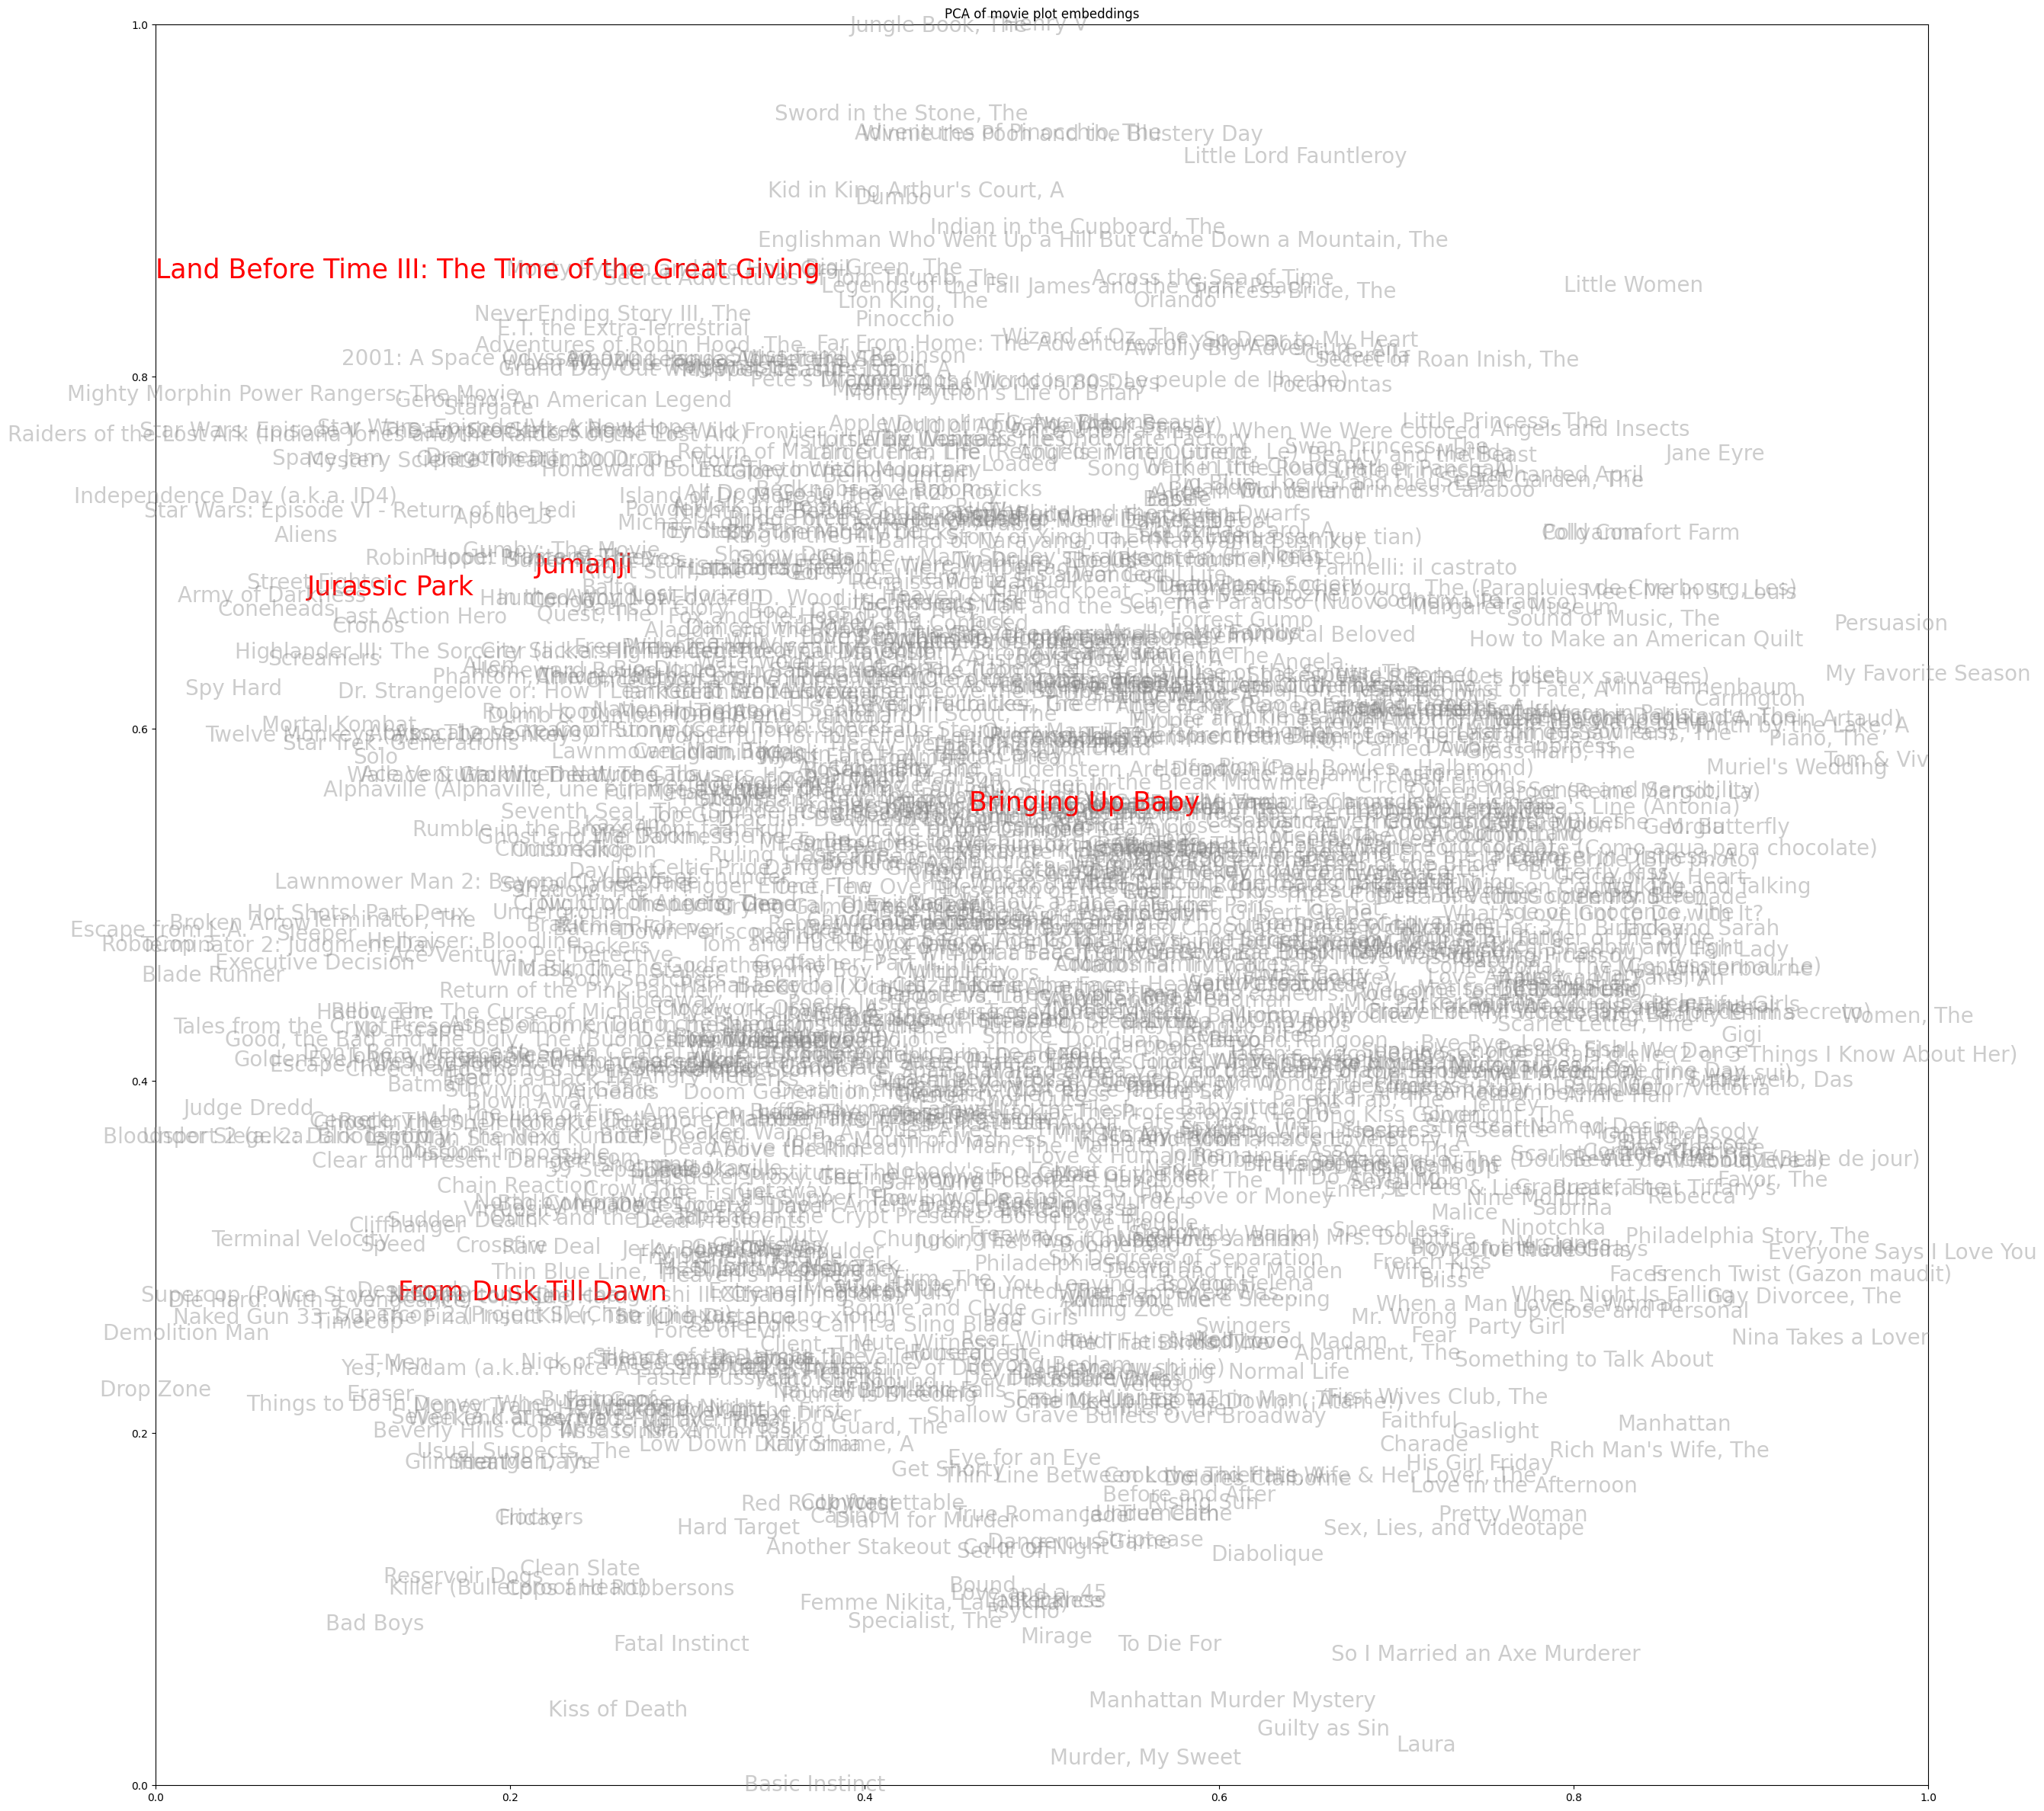

In [198]:
import matplotlib.pyplot as plt

# nr of titles to plot
n = 1000

# plot PCA version of embedding for n titles
plt.figure(figsize=(30, 30))
plt.title("PCA of movie plot embeddings")
#plt.plot(X_pca_norm[:n, 0], X_pca_norm[:n, 1], marker="o", linestyle="None", markersize=4)
    
for i in np.arange(n):
    x, y = X_pca_norm[i, :]
    text = df_plot.iloc[i]['m.title']
    if text in selected_titles:
        color = "red"
        alpha = 1
        fontsize=25
    else:
        color = "grey"
        alpha = 0.4
        fontsize = 20
    plt.text(x, y, text, horizontalalignment='center', verticalalignment='center', fontsize=fontsize, color=color, alpha=alpha)

plt.show()

__Observation__
* PCA coordinates do not seem highly correlated to embedding distances
* [x] Embedding distances do not produce intuitive results, ie by searching on keywords I find these movies: ["Jurassic Park", "Jurassic Park III", "Jurassic World", "Lost World: Jurassic Park, The"]. I'd expect that these would show up:
    * Resolved: The other movies do not have an embedding value

In [210]:
query = "MATCH (m:Movie) RETURN m.title, m.embedding"
df_results = gds.run_cypher(query)

cond_title = df_results['m.title'].str.contains("rassic")
df_results[cond_title]

,m.title,m.embedding
427,Jurassic Park,"[-0.008458033204078674, -0.0409696064889431, 0..."
1234,"Lost World: Jurassic Park, The",None
3641,Jurassic Park III,None
8737,Jurassic World,None
